<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Hadoop_single_node_cluster_setup_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90"></div></a>

# Hadoop single-node cluster setup with Python
<br>
<br>

Following Apache's official documentation [Hadoop: Setting up a Single Node Cluster](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html) we are going to launch a single node Hadoop cluster using as much as possible Python commands. This is the companion notebook to [Hadoop Setting up a Single Node Cluster](https://github.com/groda/big_data/blob/master/Hadoop_Setting_up_a_Single_Node_Cluster.ipynb), implemented in bash.



---


## Table of Contents
>[Constants](#scrollTo=qQsQTnh_OS0x)

>[Setup logging](#scrollTo=McIME8-uo3vE)

>[Start `sshd` server](#scrollTo=cVJuMb2S_Z-6)

>>[Install openssh-server](#scrollTo=1Ez3vXkfABId)

>>[Configure `sshd` service](#scrollTo=ZNrU4cMEAKos)

>>[Start `sshd` service](#scrollTo=UEHqbVByASWe)

>>[Create private/public key](#scrollTo=wBlhhfoGAZur)

>>>[Test `ssh` connection](#scrollTo=27Haz3a4_pCs)

>[Setup Hadoop](#scrollTo=q_s9ZgjHOQxb)

>>[Download core Hadoop](#scrollTo=33u0fS_0_Gut)

>>[Uncompress archive](#scrollTo=u6o4kQjNqyv7)

>>[Configure Hadoop](#scrollTo=w3_gaoxYGm6R)

>>>>[Environment variables](#scrollTo=C2bsvigF1Ghb)

>>>>[Hadoop configuration files](#scrollTo=Cz1eDw4X6r_t)

>>>>[A note on Hadoop's default configuration files](#scrollTo=UoZhdlmOeXna)

>>[Launch a single-node Hadoop cluster](#scrollTo=DK1-yry6BKI9)

>>>[Initialize the namenode](#scrollTo=dLo0tEVpBbsR)

>[Start Hadoop](#scrollTo=bGYNMicCLyBX)

>[Check namenode](#scrollTo=zamj-W64wbVa)

>>[On the command-line](#scrollTo=35UTM5dXsPYy)

>>[In the Web UI](#scrollTo=e65yJmJ9sW0V)

>[Stop Hadoop and `ssh` daemon](#scrollTo=RL57UBPWtTgF)

---

## Constants

In [1]:
# URL for downloading Hadoop
HADOOP_URL = "https://dlcdn.apache.org/hadoop/common/stable/hadoop-3.3.6.tar.gz"

# logging level (should be one of: DEBUG, INFO, WARNING, ERROR, CRITICAL)
LOGGING_LEVEL = "DEBUG" #@param ["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"]

# JAVA PATH
JAVA_PATH = '/usr/lib/jvm/java-11-openjdk-amd64'

## Setup logging

In [2]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging_level = getattr(logging, LOGGING_LEVEL.upper(), 10)

logging.basicConfig(level=logging_level, \
                    format='%(asctime)s - %(levelname)s: %(message)s', \
                    datefmt='%d-%b-%y %I:%M:%S %p')

logger = logging.getLogger('my_logger')

## Start `sshd` server

### Install `openssh-server`

In [3]:
import subprocess

In [4]:
logger.info("Installing {}".format("openssh-server"))
cmd = ["apt-get", "install", "openssh-server"]
result = subprocess.check_output(cmd, stderr=subprocess.STDOUT)


17-Oct-23 09:06:10 PM - INFO: Installing openssh-server


### Configure `sshd` service

In [5]:
import os

ssh_config_file = "/etc/ssh/ssh_config"
with open(ssh_config_file, "r+") as f:
    var = 'StrictHostKeyChecking no'
    line_found = any(line.strip().startswith(var) for line in f)
    if not line_found:
      f.seek(0, os.SEEK_END)
      f.write(var +"\n")

### Start `sshd` service

In [6]:
logger.info("Starting {}".format("openssh-server"))
cmd = ["/etc/init.d/ssh", "restart"]
result = subprocess.check_output(cmd, stderr=subprocess.STDOUT)

17-Oct-23 09:06:25 PM - INFO: Starting openssh-server


### Create private/public key

The private/public key pair is needed for passwordless authentication.

Note: for some reason `Crypto` doesn't work without `pycryptodome` (see [ModuleNotFoundError: No module named 'Crypto' Error](https://stackoverflow.com/questions/51824628/modulenotfounderror-no-module-named-crypto-error).

In [7]:
%%bash
pip install Crypto
pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00


In [8]:
import Crypto

In [9]:
from Crypto.PublicKey import RSA
key = RSA.generate(2048)
if not os.path.exists(os.path.join(os.path.expanduser('~'), '.ssh')):
  os.makedirs(os.path.join(os.path.expanduser('~'), '.ssh'), mode=700)
#os.chmod(os.path.join(os.path.expanduser('~'),'.ssh'), int('700', base=8))

with open(os.path.join(os.path.expanduser('~'), '.ssh/id_rsa'), 'wb') as f:
  os.chmod(os.path.join(os.path.expanduser('~'),'.ssh/id_rsa'), int('0600', base=8))
  f.write(key.export_key('PEM', passphrase=None))
pubkey = key.publickey()

with open(os.path.join(os.path.expanduser('~'), '.ssh/id_rsa.pub'), 'wb') as f:
    f.write(pubkey.exportKey('OpenSSH'))

In [10]:
with open(os.path.join(os.path.expanduser('~'), '.ssh/authorized_keys'), 'w') as a:
  with open(os.path.join(os.path.expanduser('~'),'.ssh/id_rsa.pub'), 'r') as f:
    a.write(f.read())
  os.chmod(os.path.join(os.path.expanduser('~'), '.ssh/authorized_keys'), int('600', base=8))


#### Test `ssh` connection

The output should be 'hi!' if the passphraseless connection is working.

In [11]:
!ssh localhost "echo hi!"

hi!


## Setup Hadoop


### Download core Hadoop
Download the latest stable version of the core Hadoop distribution from one of the download mirrors locations https://www.apache.org/dyn/closer.cgi/hadoop/common/.

In [12]:
import urllib.request
import os

file_name = os.path.basename(HADOOP_URL)
if os.path.isfile(file_name):
   logger.info("{} already exists, not downloading".format(file_name))
else:
  logger.info("Downloading {}".format(file_name))
  urllib.request.urlretrieve(HADOOP_URL, file_name)

17-Oct-23 09:06:39 PM - INFO: Downloading hadoop-3.3.6.tar.gz


### Uncompress archive

In [13]:
import tarfile

dir_name = file_name[:-7]
if os.path.exists(dir_name):
  logger.info("{} is already uncompressed".format(file_name))
else:
  logger.info("Uncompressing {}".format(file_name))
  tar = tarfile.open(file_name)
  tar.extractall()
  tar.close()

17-Oct-23 09:07:13 PM - INFO: Uncompressing hadoop-3.3.6.tar.gz


### Configure Hadoop



##### Environment variables

In [14]:
os.environ['HADOOP_HOME'] = os.path.join('/content', dir_name)
os.environ['PATH'] = ':'.join([os.path.join(os.environ['HADOOP_HOME'], 'bin'), os.environ['PATH']])

##### Hadoop configuration files

We're going to edit two important Hadoop configuration files:


*   `core-site.xml` containing the *site-specific configuration* of the Hadoop core
*   `hdfs-site.xml` containing the *site-specific configuration* of Hadoop's HDFS

The file `hadoop-env.sh` is a helper file containing environment variables needed by the shell scripts used to start the cluster.

All these files can be found in `/etc/hadoop` under `$HADOOP_HOME` (the Hadoop installation folder).

In [15]:
core_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/core-site.xml')
hdfs_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/hdfs-site.xml')
hadoop_env_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/hadoop-env.sh')

In [16]:
import xml.etree.ElementTree as ET
import xml.dom.minidom

In [17]:
def edit_conf_file(file, propertyname, propertyvalue):
  tree = ET.parse(file)
  root = tree.getroot()

  # remove all properties
  for el in list(root):
      root.remove(el)

  logger.info("add property {} to {}".format(propertyname, file))
  property = ET.SubElement(root, 'property')
  name = ET.SubElement(property, 'name')
  name.text = propertyname
  value = ET.SubElement(property, 'value')
  value.text = propertyvalue
  tree.write(file, encoding='utf-8', xml_declaration=True)

  # pretty-print
  dom = xml.dom.minidom.parse(file)
  print(dom.toprettyxml())

edit_conf_file(core_site_file, 'fs.defaultFS', 'hdfs://localhost:9000')
edit_conf_file(hdfs_site_file, 'dfs.replication', '1')

17-Oct-23 09:07:31 PM - INFO: add property fs.defaultFS to /content/hadoop-3.3.6/etc/hadoop/core-site.xml
17-Oct-23 09:07:31 PM - INFO: add property dfs.replication to /content/hadoop-3.3.6/etc/hadoop/hdfs-site.xml


<?xml version="1.0" ?>
<configuration>
	

	<property>
		<name>fs.defaultFS</name>
		<value>hdfs://localhost:9000</value>
	</property>
</configuration>

<?xml version="1.0" ?>
<configuration>
	


	<property>
		<name>dfs.replication</name>
		<value>1</value>
	</property>
</configuration>



In [18]:
users = ['HDFS_NAMENODE_USER', \
         'HDFS_DATANODE_USER', \
         'HDFS_SECONDARYNAMENODE_USER', \
         'YARN_RESOURCEMANAGER_USER', \
         'YARN_NODEMANAGER_USER']

logger.info("Editing {}".format(hadoop_env_file))

with open(hadoop_env_file, "r+") as f:
  for u in users:
    var = 'export ' + u + '=root'
    line_found = any(line.startswith(var) for line in f)
    if not line_found:
      f.seek(0, os.SEEK_END)
      f.write(var +"\n")
  line_found = any(line.startswith('export JAVA_HOME=') for line in f)
  if not line_found:
      f.seek(0, os.SEEK_END)
      f.write('export JAVA_HOME='+JAVA_PATH+"\n")

17-Oct-23 09:07:31 PM - INFO: Editing /content/hadoop-3.3.6/etc/hadoop/hadoop-env.sh


##### A note on Hadoop's default configuration files

Hadoop's default configuration files are:

*  `core-default.xml`
*  `hdfs-default.xml`
*  `yarn-default.xml`
*  `mapred-default.xml`

They are read-only files that contain all default values for Hadoop properties (see [cluster setup](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html#Configuring_Hadoop_in_Non-Secure_Mode)) and can be viewed at:


In [19]:
import glob
list(glob.iglob(os.environ['HADOOP_HOME']+ '/**/*default.xml', recursive=True))

['/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-rbf/hdfs-rbf-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-common/core-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-yarn/hadoop-yarn-common/yarn-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-mapreduce-client/hadoop-mapreduce-client-core/mapred-default.xml']

By providing site-specific configuration files one can override any of the default properties.

In our case we set `fs.defaultFS` (the URI of the default file system) to `hdfs://localhost:9000` and changed `dfs.replication` to $1$ (the default is $3$) in `hdfs-site.xml`.


### Launch a single-node Hadoop cluster

#### Initialize the namenode

In [20]:
logger.info("Formatting NameNode")
cmd = ["hdfs", "namenode", "-format", "-nonInteractive"]
result = subprocess.call(cmd, stderr=subprocess.STDOUT)

17-Oct-23 09:07:31 PM - INFO: Formatting NameNode


## Start Hadoop

In [21]:
!$HADOOP_HOME/sbin/start-dfs.sh

Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [e5e881af2f97]
e5e881af2f97: Warning: Permanently added 'e5e881af2f97' (ED25519) to the list of known hosts.


## Check namenode

### On the command-line

In [22]:
!hdfs dfsadmin -report

Configured Capacity: 115658190848 (107.72 GB)
Present Capacity: 84629557248 (78.82 GB)
DFS Remaining: 84629532672 (78.82 GB)
DFS Used: 24576 (24 KB)
DFS Used%: 0.00%
Replicated Blocks:
	Under replicated blocks: 0
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 127.0.0.1:9866 (localhost)
Hostname: e5e881af2f97
Decommission Status : Normal
Configured Capacity: 115658190848 (107.72 GB)
DFS Used: 24576 (24 KB)
Non DFS Used: 31011856384 (28.88 GB)
DFS Remaining: 84629532672 (78.82 GB)
DFS Used%: 0.00%
DFS Remaining%: 73.17%
Configured Cache Capacity: 0 (0 B)
Cache

### In the Web UI

Open the Web UI in another tab in the browser with Google Colab's `output` library (source: https://github.com/googlecolab/colabtools/, documentation: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=95mvP1VeYETf).

In [23]:
from google.colab import output
port = 9870
output.serve_kernel_port_as_window(port, path='/index.html')

<IPython.core.display.Javascript object>

This is what you should see in a newly opened tab or window in your browser
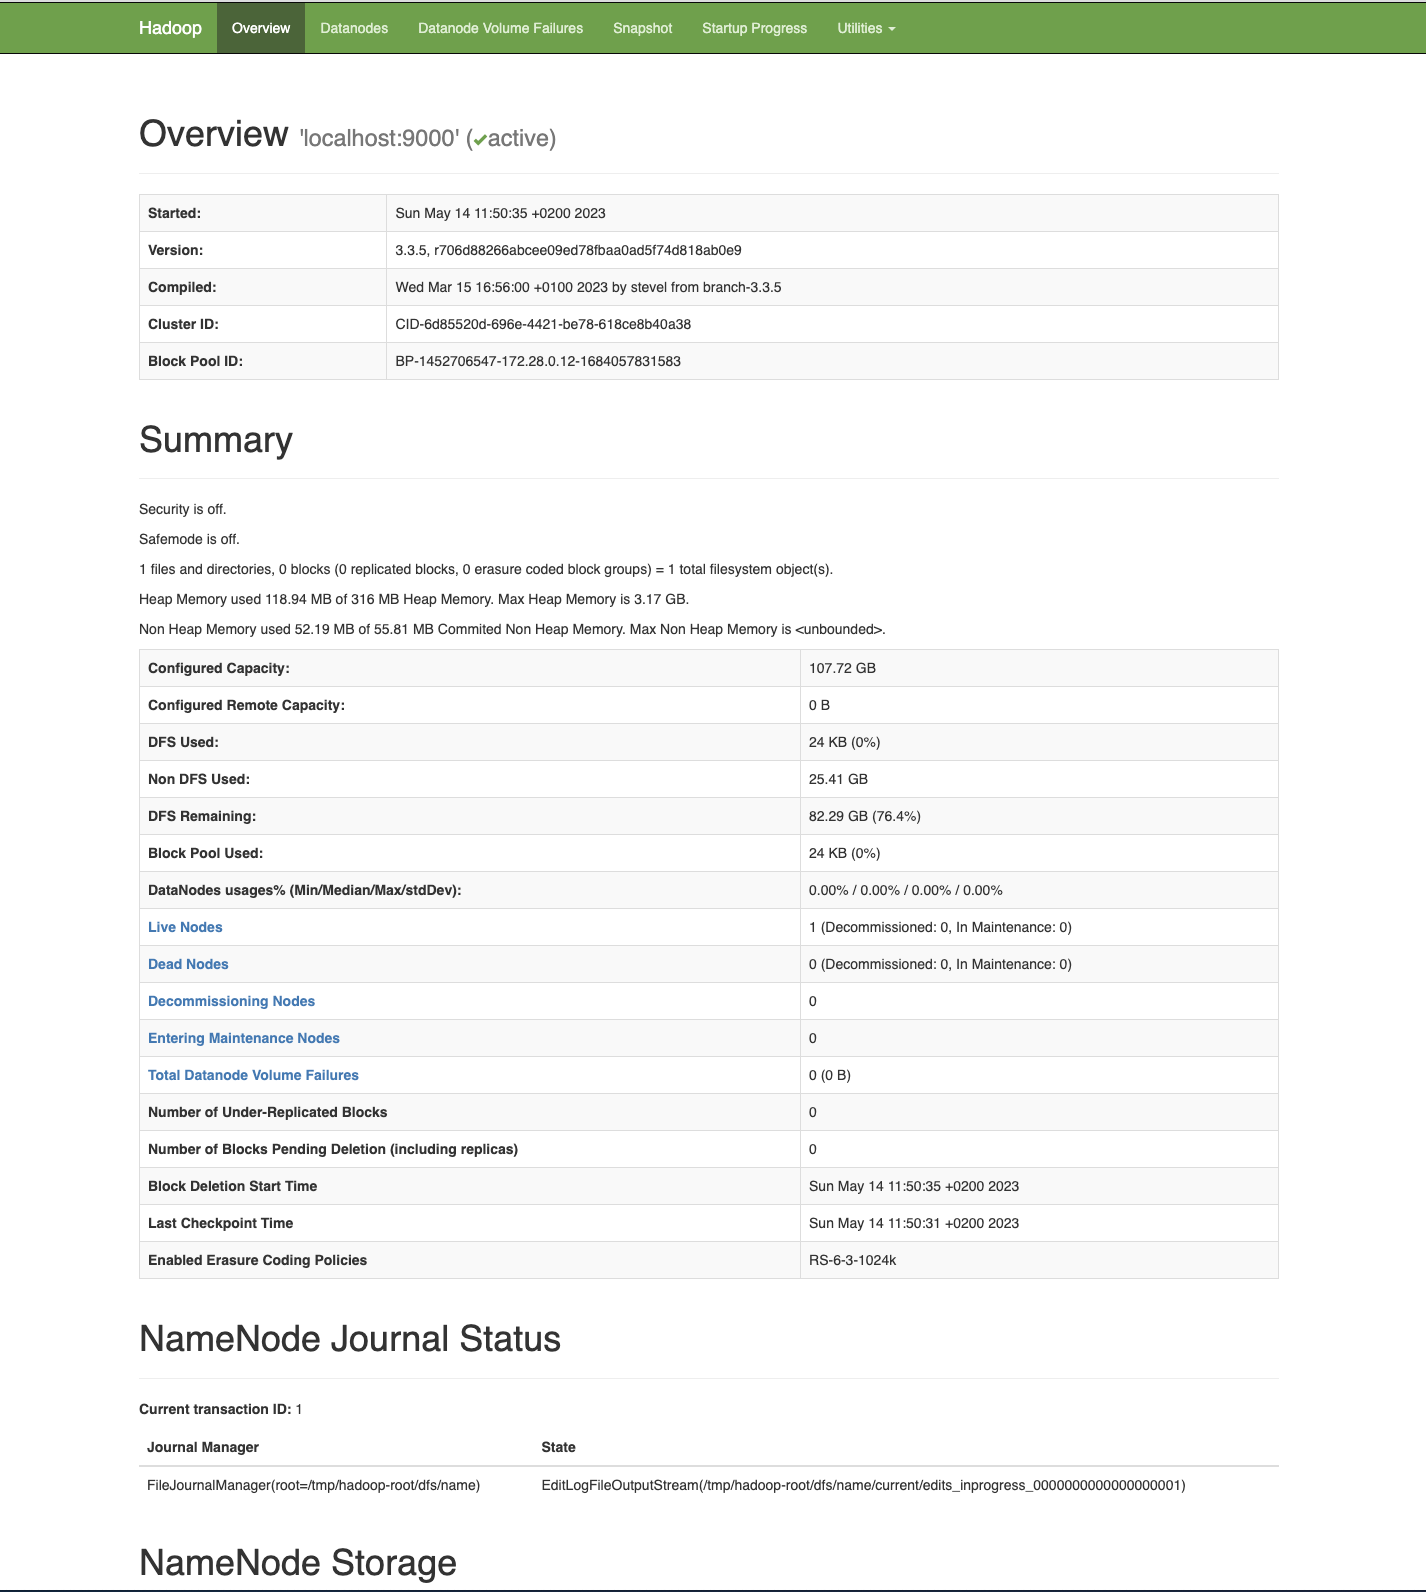

## Stop Hadoop and `ssh` daemon

In [24]:
!$HADOOP_HOME/sbin/stop-dfs.sh

Stopping namenodes on [localhost]
Stopping datanodes
Stopping secondary namenodes [e5e881af2f97]


In [25]:
!/etc/init.d/ssh stop

 * Stopping OpenBSD Secure Shell server sshd
   ...done.
